# Introduction
> In this notebook, we will be designing a ResNet from scratch.
>> The Architecture as per official paper is attached below
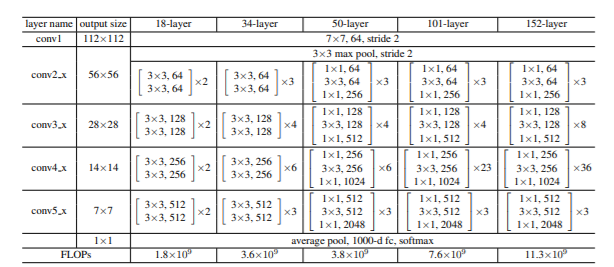



# Getting Started
>  Let's choose to design ResNet101 from scratch in Keras.
>  > Following are the points to be noted.
* Residual Networks contains two major blocks i.e Identity mapping blocks and a convolutional block which is depicted as convN_x where N = 2 to 5.
Identity mapping blocks expect the same Input and Output whereas the 
* convolutional blocks overcomes concatenation of varying dimension of Input-Output by using a 1*1 convolution in the skip connection. 
>  >



In [1]:
import tensorflow.keras as keras
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, ReLU, Add, Input, MaxPooling2D, AveragePooling2D, Activation, Flatten, Dense
from keras.optimizers import Adam,SGD
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img

In [2]:
# #defining the identity mapping block
# def identity_mapping_block(input_node, Filter, kernel_size):
#   #saving the initial input to a new node to entertain concatenation at a later stage
#   init_input = input_node
#   #fetching filter for each block
#   F1, F2, F3 = Filter
#   #Block 1 : Conv -> Batch Norm -> Relu
#   output_node = Conv2D(F1,(1,1),(1,1),padding='valid', kernel_initializer='glorot_uniform')(input_node)
#   output_node = BatchNormalization()(output_node)
#   output_node = ReLU()(output_node)
#   #Block2 : Conv -> Batch Norm -> Relu (Notice that it is not kernel_size won't be 1 as per the architecture)
#   output_node = Conv2D(F2,(kernel_size,kernel_size),(1,1),padding='same',kernel_initializer='glorot_uniform')(output_node)
#   output_node = BatchNormalization()(output_node)
#   output_node = ReLU()(output_node)
#   #Block 3 : Conv -> Batch Norm ; To be noted that Relu is applied after concatenation
#   output_node = Conv2D(F3,(1,1),(1,1),padding='valid',kernel_initializer='glorot_uniform')(output_node)
#   output_node = BatchNormalization()(output_node)

#   #Concatenation stage via Skip connection
#   output_node = Add()([output_node, init_input])
#   output_node = ReLU()(output_node)
#   #finally returning the output
#   return output_node


def identity_mapping_block(X, filters,f):

    # Retrieve Filters
    F1, F2, F3 = filters  # F1=64,F2=64,256
    
    X_shortcut = X
    
    # First  layer
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    
    # Second  layer
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third  layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)

    # Final step: Add shortcut value to F(X), and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [13]:
#defining the convolutional block 
#To be noted that the speciality of this block is init_input passing through a 1*1 convolution of stride 2 prior concatenating to the output of the blocks through skip connection.
def convolutional_block(input_node, Filter,kernel_size, skip_conv_stride):
  #saving the initial input to a new node to entertain concatentation at a a later stage.
  init_input = input_node
  #fetching filter of each node
  F1,F2, F3 = Filter
  #Block 1 : Conv -> Batch Norm -> Relu
  output_node = Conv2D(F1,(1,1),(skip_conv_stride,skip_conv_stride),padding='same', kernel_initializer='glorot_uniform')(input_node)
  output_node = BatchNormalization()(output_node)
  output_node = ReLU()(output_node)
  #Block2 : Conv -> Batch Norm -> Relu (Notice that it is not kernel_size won't be 1 as per the architecture)
  output_node = Conv2D(F2,(kernel_size,kernel_size),(1,1),padding='same',kernel_initializer='glorot_uniform')(output_node)
  output_node = BatchNormalization()(output_node)
  output_node = ReLU()(output_node)
  #Block 3 : Conv -> Batch Norm ; To be noted that Relu is applied after concatenation
  output_node = Conv2D(F3,(1,1),(1,1),padding='valid',kernel_initializer='glorot_uniform')(output_node)
  output_node = BatchNormalization()(output_node)
  #Skip connection's Input convolved with convolution stage
  init_input= Conv2D(F3, (1,1),(skip_conv_stride,skip_conv_stride),padding ='valid', kernel_initializer='glorot_uniform')(init_input)
  #concatenation

  output_node = Add()([init_input, output_node])
  output_node = ReLU()(output_node)
  return output_node



# def convolutional_block(X, filters,f ,s = 2):

    
#     # Retrieve Filters
#     F1, F2, F3 = filters
    
#     # Save the input value
#     X_shortcut = X


#     # First layer 
#     X = Conv2D(F1, (1, 1), strides = (s,s))(X) # 1,1 is filter size
#     X = BatchNormalization(axis = 3)(X)  # normalization on channels
#     X = Activation('relu')(X)

      
#     # Second layer  (f,f)=3*3 filter by default
#     X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same')(X)
#     X = BatchNormalization(axis = 3)(X)
#     X = Activation('relu')(X)


#     # Third layer
#     X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
#     X = BatchNormalization(axis = 3)(X)


#     ##### SHORTCUT PATH #### 
#     X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid')(X_shortcut)
#     X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

#     # Final step: Add shortcut value here, and pass it through a RELU activation 
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)
    
    
#     return X

In [14]:
#Now using these blocks to build up ResNet 101 architecture.
def ResNet101(Input_shape, num_classes):
  #creating an input tensor
  input_tensor = Input(Input_shape)
  #Zero Padding the input to 3*3
  output = ZeroPadding2D((3,3))(input_tensor)
  #Now stacking stages as per the research paper
  # Stage : conv1 : 7*7 with stride 2 and 64 filters
  output = Conv2D(64,(7,7),(2,2),padding='valid',kernel_initializer='glorot_uniform')(output)
  output = BatchNormalization()(output)
  output = ReLU()(output)

  #Stage 2_x: Max Pool(3,3,stride 2) with 3 blocks of filter 64,64,256 (1 with different input and output(Convolutional block) and 2 with same i/o i.e (Identity block))
  output = MaxPooling2D((3,3),strides=(2,2))(output)
  #Now stacking the 3 blocks with filter: 64,64,256
  Filter_2 = [64,64,256]
  kernel_size_2 = 3
  output = convolutional_block(output,Filter_2,kernel_size_2,1)
  output = identity_mapping_block(output,Filter_2, kernel_size_2)
  output = identity_mapping_block(output,Filter_2, kernel_size_2)

  #Stage 3_x: 8 blocks i.e 7 identity_mapping and 1 convolutional block
  Filter_3 = [128,128,512]
  kernel_size_3 = 3
  output = convolutional_block(output,Filter_3,kernel_size_3,2)
  for _ in range(7):
    output = identity_mapping_block(output,Filter_3, kernel_size_3)

  #Stage 4_x: 36 blocks i.e 35 identity_mapping and 1 convolutional block
  Filter_4 = [256,256,1024]
  kernel_size_4 = 3
  output = convolutional_block(output,Filter_4,kernel_size_4,2)
  for _ in range(35):
    output = identity_mapping_block(output,Filter_4, kernel_size_4)

  #Stage 5_x: 3 blocks of filter 64,64,256 (1 with different input and output(Convolutional block) and 2 with same i/o i.e (Identity block))
  #Now stacking the 3 blocks with filter: 64,64,256
  Filter_5 = [512,512,2048]
  kernel_size_5 = 3
  output = convolutional_block(output,Filter_2,kernel_size_5,2)
  output = identity_mapping_block(output,Filter_2, kernel_size_5)
  output = identity_mapping_block(output,Filter_2, kernel_size_5)

  #Stage 6 : Average Pooling Layer
  output = AveragePooling2D((2,2))(output)

  #Stage 7: 
  output = Flatten()(output)
  output = Dense(num_classes,activation='softmax', kernel_initializer='glorot_uniform')(output)

  #now compiling model with Input and output
  model = Model(inputs= input_tensor, outputs= output)
  #returning model
  return model


In [15]:
#Now creating a model instance
Input_shape =(224,224,3)
classes = 3
Resnet = ResNet101(Input_shape, classes)
print(Resnet.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 112, 112, 64) 9472        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 112, 112, 64) 256         conv2d_15[0][0]                  
______________________________________________________________________________________________